# 분석에 필요한 라이브러리 설치

In [ ]:
# # 필요한 라이브러리 설치
# !pip install plotnine kmodes tqdm ipypb

In [1]:
import sqlite3
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotnine import *
import plotnine

In [4]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [5]:
from tqdm import tqdm_notebook
import time
from ipypb import ipb

In [6]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

# 분석할 테이블 불러오기

In [7]:
# 영수증 번호가 E인 것들 select + 1번 + 5번 연결
con = sqlite3.connect("lpoint.db", isolation_level=None) # lpoint db 생성 or 연결

df2 = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c AND P.rct_no LIKE 'E%'
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

# 불러온 테이블 컬럼명 한글로 재설정

In [8]:
df2.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
              '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
              '구매시간', '구매금액', '구매수량']

# 군집화에 사용할 필요한 컬럼명만 가져오기

In [9]:
ndf2 = df2[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매시간', '구매금액', '구매수량']]

# 구매월 변수 추가

In [10]:
# 구매월 추가
ndf2['구매월'] = df2['구매일자'].map(lambda x: str(x)[4:6]+'월')

In [11]:
ndf2.head()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월
0,여성,30대,Z11,A02,세제/위생,11,13500,1,01월
1,여성,30대,Z11,A02,음료,11,5300,1,01월
2,여성,30대,Z11,A02,퍼스널케어,11,5900,1,01월
3,여성,30대,Z11,A06,세제/위생,11,10000,1,01월
4,여성,30대,Z11,A06,세제/위생,11,5000,5,01월


# 숫자형 변수 최대최소스케일링

In [12]:
scaled_X = MinMaxScaler().fit_transform(ndf2[['구매시간', '구매금액', '구매수량']])
ndf2[['구매시간', '구매금액', '구매수량']] = scaled_X

# Categorical 변수 정해주기

In [13]:
# Get the position of categorical columns
catcol = [ndf2.columns.get_loc(col) for col in list(ndf2.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매월']
Categorical columns position : [0, 1, 2, 3, 4, 8]


# 데이터 프레임을 행렬 형태로 만들어주기

In [14]:
# convert dataframe to matrix
dfmatrix = ndf2.to_numpy()
dfmatrix

array([['여성', '30대', 'Z11', ..., 0.0019174718632772533, 0.0, '01월'],
       ['여성', '30대', 'Z11', ..., 0.0007526989705538311, 0.0, '01월'],
       ['여성', '30대', 'Z11', ..., 0.0008379262553872522, 0.0, '01월'],
       ...,
       ['여성', '50대', 'Z17', ..., 0.004872017737502519, 0.0, '01월'],
       ['여성', '50대', 'Z17', ..., 0.01264190520481608, 0.0, '04월'],
       ['여성', '50대', 'Z17', ..., 0.007102131690643706, 0.0, '05월']],
      dtype=object)

# Elbow Method 

In [15]:
# Choose optimal K using Elbow method
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [02:15:49<37:01, 1358.24s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 227445.00583915706
Init: 

Run: 10, iteration: 2/100, moves: 9740, ncost: 199828.31005839334
Run: 10, iteration: 3/100, moves: 5689, ncost: 199744.28006193333
Run: 10, iteration: 4/100, moves: 5006, ncost: 199662.51128188247
Run: 10, iteration: 5/100, moves: 198, ncost: 199662.4076347502
Run: 10, iteration: 6/100, moves: 0, ncost: 199662.4076347502
Best run was number 6
Cluster initiation: 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 124648, ncost: 191139.11508853023
Run: 1, iteration: 2/100, moves: 43035, ncost: 190519.92963440687
Run: 1, iteration: 3/100, moves: 19694, ncost: 190352.06332629075
Run: 1, iteration: 4/100, moves: 24813, ncost: 190138.99177587964
Run: 1, iteration: 5/100, moves: 21576, ncost: 189963.61557907768
Run: 1, iteration: 6/100, moves: 617, ncost: 189961.6720576059
Run: 1, iteration: 7/100, moves: 3, ncost: 189961.6719879963
Run: 1, iteration: 8/100, moves: 0, ncost: 189961.6719879963
Init: initializing centroids
Init: i

Run: 7, iteration: 3/100, moves: 40813, ncost: 181175.52286154032
Run: 7, iteration: 4/100, moves: 9789, ncost: 181108.5354354127
Run: 7, iteration: 5/100, moves: 5959, ncost: 181068.9740373856
Run: 7, iteration: 6/100, moves: 3628, ncost: 181057.4101597427
Run: 7, iteration: 7/100, moves: 573, ncost: 181056.05098466182
Run: 7, iteration: 8/100, moves: 3, ncost: 181056.05094463585
Run: 7, iteration: 9/100, moves: 0, ncost: 181056.05094463585
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 96920, ncost: 181389.997604599
Run: 8, iteration: 2/100, moves: 13088, ncost: 181297.62806335
Run: 8, iteration: 3/100, moves: 5570, ncost: 181279.73442494316
Run: 8, iteration: 4/100, moves: 840, ncost: 181279.10255037269
Run: 8, iteration: 5/100, moves: 0, ncost: 181279.10255037269
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 75054, ncost: 183572.1017487254
Run: 9, ite

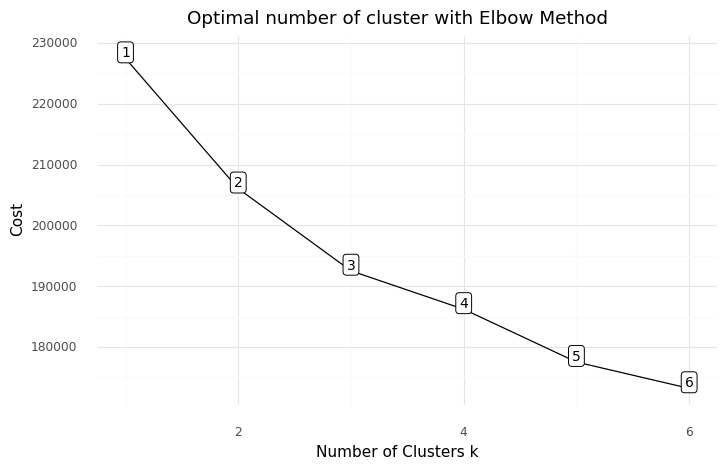

<ggplot: (121828968180)>

In [16]:
# Elbow 메소드 시각화
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

- 위의 결과 3번이 제일 좋아 보임

In [30]:
df_cost

,Cluster,Cost
0,1,227445.005839
1,2,206044.170110
2,3,192533.346000
3,4,186216.307273
4,5,177536.577802
5,6,173205.125643


- 우선 3을 군집개수로 선택

# 군집개수 선택 후 모델 적합하기

In [29]:
# Fit the cluster
# n_clusters = 3으로 한다
kprototype = KPrototypes(n_clusters = 3, init = 'Huang',
                                 random_state = 0, verbose = True)
kprototype.fit_predict(dfmatrix, categorical = catcol)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 100396, ncost: 194986.46403230613
Run: 1, iteration: 2/100, moves: 57003, ncost: 194010.26861544067
Run: 1, iteration: 3/100, moves: 7438, ncost: 193995.92006688766
Run: 1, iteration: 4/100, moves: 0, ncost: 193995.92006688766
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 112056, ncost: 193201.14861124384
Run: 2, iteration: 2/100, moves: 22256, ncost: 192962.1032655044
Run: 2, iteration: 3/100, moves: 4246, ncost: 192951.06675155438
Run: 2, iteration: 4/100, moves: 87, ncost: 192951.04840244266
Run: 2, iteration: 5/100, moves: 0, ncost: 192951.04840244266
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 62742, ncost: 195626.74532195338
Run: 3, iteration: 2/100, moves: 8735, ncost: 195521.3474205918
Run: 3, iteration: 3/100, moves: 8232, ncost: 19

array([2, 2, 2, ..., 0, 0, 0], dtype=uint16)

# 기존 데이터 프레임에 분류된 군집 추가하기

In [31]:
#new column for cluster labels associated with each subject
df2['cluster'] = kprototype.labels_ # 모든 컬럼 들어있는 데이터프레임에 군집 추가
ndf2['cluster'] = kprototype.labels_ # 군집화에 사용된 컬럼 들어있는 데이터프레임에 군집 추가

In [48]:
# 데이터 csv파일로 저장
df2.to_csv("pdde_online_all.csv", index=False, encoding="utf-8-sig")
ndf2.to_csv("pdde_online_cateogric.csv", index=False, encoding="utf-8-sig")

In [32]:
df2.head()

,고객번호,성별,연령대,거주지분류대코드,영수증번호,구매일자,채널구분,제휴사,상품코드,상품대분류명,상품중분류명,상품소분류명,구매시간,구매금액,구매수량,cluster
0,M000136117,여성,30대,Z11,E02000670648,20210104,2,A02,PD0601,세제/위생,세탁세제,섬유유연제/향기지속제,11,13500,1,2
1,M000136117,여성,30대,Z11,E02000670648,20210104,2,A02,PD1164,음료,과채음료,어린이음료,11,5300,1,2
2,M000136117,여성,30대,Z11,E02000670648,20210104,2,A02,PD1847,퍼스널케어,여성위생용품,생리대,11,5900,1,2
3,M000136117,여성,30대,Z11,E06000715170,20210104,2,A06,PD0611,세제/위생,화장지/티슈,롤티슈,11,10000,1,2
4,M000136117,여성,30대,Z11,E06000715170,20210104,2,A06,PD0613,세제/위생,화장지/티슈,물티슈,11,5000,5,2


In [33]:
ndf2.head()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월,cluster
0,여성,30대,Z11,A02,세제/위생,0.478261,0.001917,0.000000,01월,2
1,여성,30대,Z11,A02,음료,0.478261,0.000753,0.000000,01월,2
2,여성,30대,Z11,A02,퍼스널케어,0.478261,0.000838,0.000000,01월,2
3,여성,30대,Z11,A06,세제/위생,0.478261,0.001420,0.000000,01월,2
4,여성,30대,Z11,A06,세제/위생,0.478261,0.000710,0.040404,01월,2


In [7]:
# 저장한 데이터 불러오기
df2 = pd.read_csv('pdde_online_all.csv', encoding='utf-8')
df2.tail()

,고객번호,성별,연령대,거주지분류대코드,영수증번호,구매일자,채널구분,제휴사,상품코드,상품대분류명,상품중분류명,상품소분류명,구매시간,구매금액,구매수량,cluster
375779,M999962961,여성,50대,Z17,E02024505549,20210515,2,A02,PD1441,채소,잎채소,쌈채소류,10,1180,1,1
375780,M999962961,여성,50대,Z17,E06002810292,20210113,2,A06,PD0959,여성의류,여성의류아우터,여성재킷,18,129000,1,0
375781,M999962961,여성,50대,Z17,E06004609359,20210122,2,A06,PD0954,여성의류,여성의류상의,여성스웨터/풀오버,14,34300,1,0
375782,M999962961,여성,50대,Z17,E06025413888,20210406,2,A06,PD0967,여성의류,여성의류하의,여성바지,17,89000,1,0
375783,M999962961,여성,50대,Z17,E06035713248,20210503,2,A06,PD1889,화장품/뷰티케어,메이크업,BB/파운데이션/컴팩트류,22,50000,1,0


In [8]:
ndf2 = pd.read_csv('pdde_online_cateogric.csv', encoding='utf-8')
ndf2.tail()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월,cluster
375779,여성,50대,Z17,A02,채소,0.434783,0.000167,0.0,05월,1
375780,여성,50대,Z17,A06,여성의류,0.782609,0.018324,0.0,01월,0
375781,여성,50대,Z17,A06,여성의류,0.608696,0.004872,0.0,01월,0
375782,여성,50대,Z17,A06,여성의류,0.739130,0.012642,0.0,04월,0
375783,여성,50대,Z17,A06,화장품/뷰티케어,0.956522,0.007102,0.0,05월,0


In [9]:
# 카테고리컬 변수들의 최빈값 확인
ndf2[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매월', 'cluster']].groupby('cluster').agg([pd.Series.mode]).T

,cluster,0,1,2
성별,mode,여성,여성,여성
연령대,mode,40대,40대,30대
거주지분류대코드,mode,Z17,Z17,Z10
제휴사,mode,A03,A02,A02
상품대분류명,mode,축산물,대용식,채소
구매월,mode,01월,02월,04월


In [15]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [17]:
# 군집 나누기
online_0 = ndf2[ndf2['cluster'] == 0]
online_1 = ndf2[ndf2['cluster'] == 1]
online_2 = ndf2[ndf2['cluster'] == 2]

[Text(0.5, 1.0, 'group 2')]

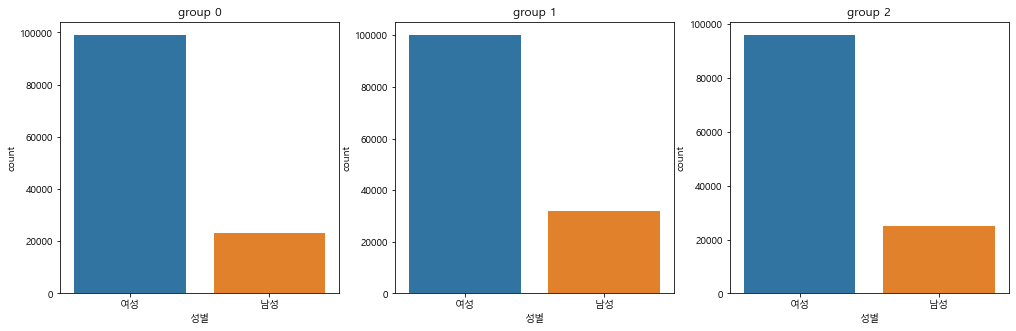

In [45]:
# 군집별 성별 비교 
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='성별', data=online_0)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='성별', data=online_1)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='성별', data=online_2)
c.set(title = "group 2")

- 성별로는 군집별로 유의미한 차이 없었음

[Text(0.5, 1.0, 'group 2')]

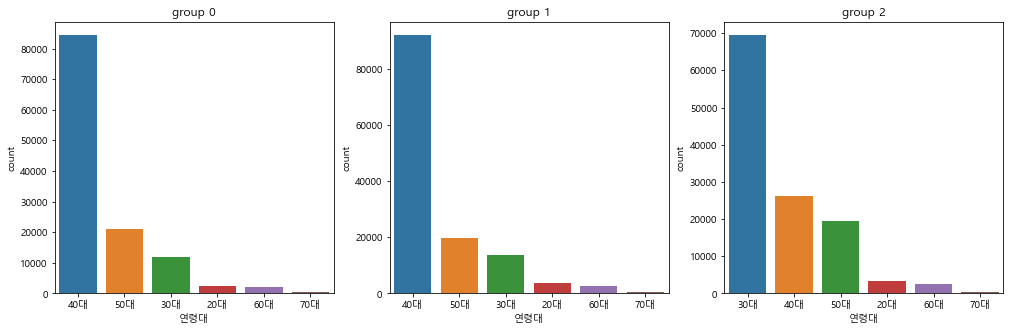

In [50]:
# 연령대
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='연령대', data=online_0, order = online_0['연령대'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='연령대', data=online_1, order = online_1['연령대'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='연령대', data=online_2, order = online_2['연령대'].value_counts().index)
c.set(title = "group 2")

- 연령대의 경우 group 0,1은 주로 4-50대, 2는 3-40대

[Text(0.5, 1.0, 'group 2')]

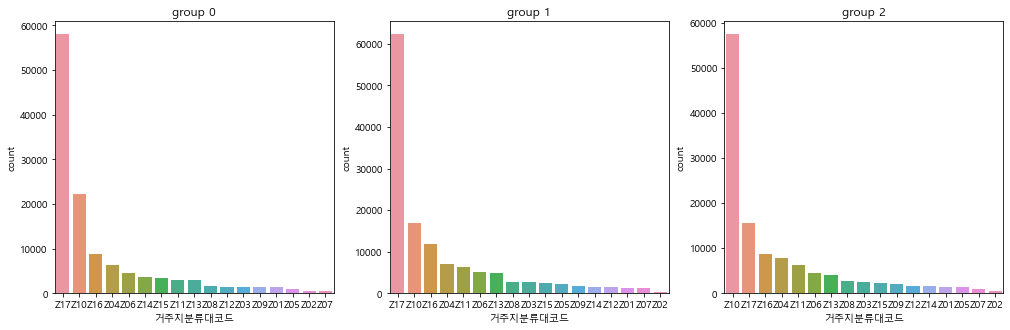

In [51]:
# 거주지분류대코드
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='거주지분류대코드', data=online_0, order = online_0['거주지분류대코드'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='거주지분류대코드', data=online_1, order = online_1['거주지분류대코드'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='거주지분류대코드', data=online_2, order = online_2['거주지분류대코드'].value_counts().index)
c.set(title = "group 2")

- 거주지의 경우 group0과 1은 대부분 Z17, group2는 대부분 10

[Text(0.5, 1.0, 'group 2')]

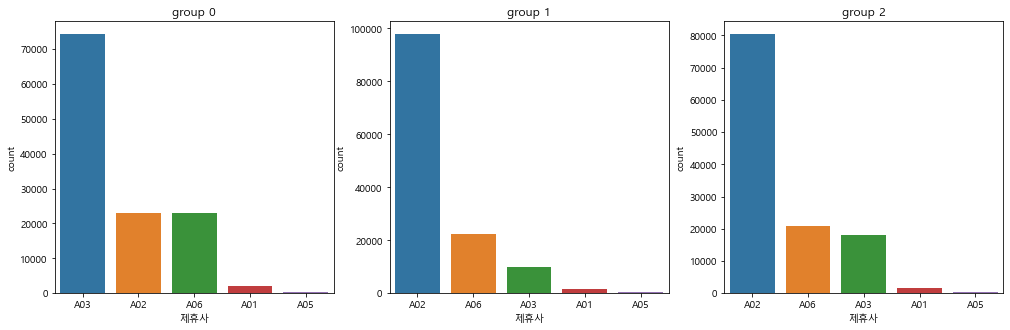

In [52]:
# 제휴사
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='제휴사', data=online_0, order = online_0['제휴사'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='제휴사', data=online_1, order = online_1['제휴사'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='제휴사', data=online_2, order = online_2['제휴사'].value_counts().index)
c.set(title = "group 2")

- group0은 주 제휴사가 A03, A02, A06 순
- group1,2는 주 제휴사가 A02, A06, A03 순 

[Text(0.5, 1.0, 'group 2')]

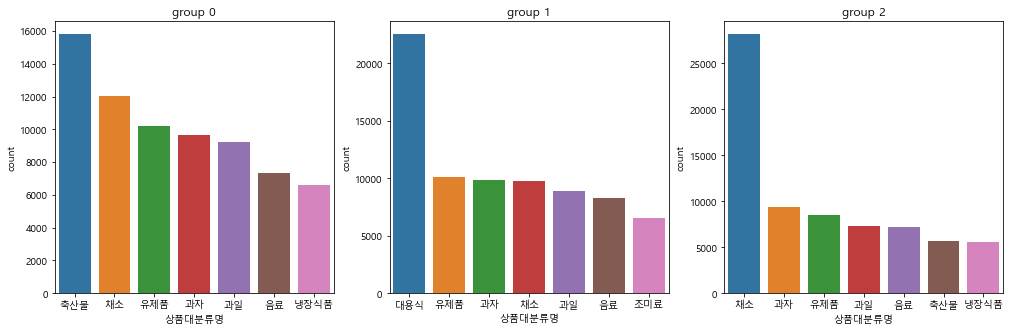

In [65]:
# 상품대분류명
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='상품대분류명', data=online_0, order = online_0['상품대분류명'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='상품대분류명', data=online_1, order = online_1['상품대분류명'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='상품대분류명', data=online_2, order = online_2['상품대분류명'].value_counts().index[:7])
c.set(title = "group 2")

- group0는 축산물, 채소, 유제품, 과자, 과일, 음료, 냉장식품 순 -> 축산물, 채소와 같이 주로 저녁식사?
- group1은 대용식, 유제품, 과자, 채소, 과일, 음료, 조미료 순 -> 대용식(압도적으로 많이 구매), 유제품, 과자와 같이 주로 간편하게 먹을 수 있는 것들
- group2는 채소, 과자, 유제품, 과일, 음료, 축산물, 냉장식품 순 -> 채소를 압도적으로 많이 구매

[Text(0.5, 1.0, 'group 2')]

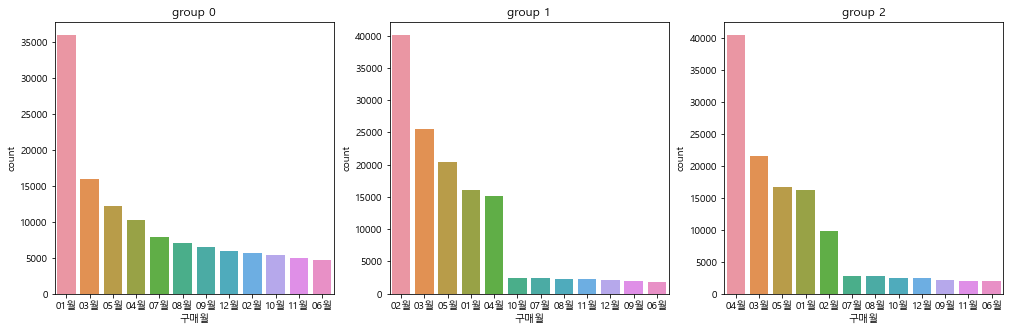

In [66]:
# 구매월
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매월', data=online_0, order = online_0['구매월'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매월', data=online_1, order = online_1['구매월'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매월', data=online_2, order = online_2['구매월'].value_counts().index)
c.set(title = "group 2")

- 모든 그룹 모두 상반기에 구매 많이하는 경향
- 그중에서도 group1은 특히 1월에, group1은 2월에, group3는 4월에 구매를 많이하는 경향.
- 다른 그룹보다 group0은 비교적 하반기에도 구매 많이 하는 편

In [10]:
# 숫자형 변수는 df2로 분석 (스케일링 해줬기 때문)
df2[['구매시간', '구매금액', '구매수량', 'cluster']].groupby('cluster').agg(['mean', 'median']).T

cluster                 0             1             2
구매시간 mean       16.228394     11.047108     14.018074
     median     16.000000     11.000000     14.000000
구매금액 mean    18302.671292  16466.300074  16927.707592
     median   5880.000000   4980.000000   4380.000000
구매수량 mean        1.348454      1.338230      1.316828
     median      1.000000      1.000000      1.000000

- 구매시간 : group0은 주로 4시경, group1은 주로 오전 11시경, group2는 주로 오후 2시경 구매
- 구매금액 : group0가 평균 약 18300원 중앙값 5880원 / group1은 평균 약 16470원 중앙값 4980원 / group2는 평균 약 16930원, 중앙값 4380원으로 group0가 group1,2에 비해 더 금액이 큼
- 구매수량 : 모두 다 비슷

In [69]:
online0 = df2[df2['cluster'] == 0]
online1 = df2[df2['cluster'] == 1]
online2 = df2[df2['cluster'] == 2]

[Text(0.5, 1.0, 'group 2')]

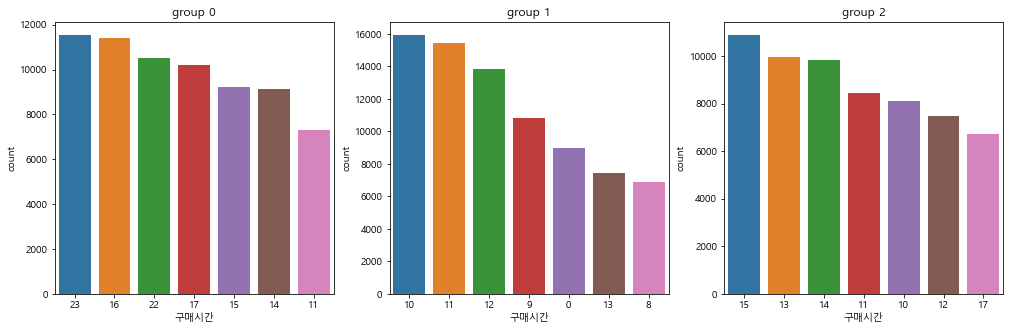

In [70]:
# 구매시간은 따로 확인해보기
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매시간', data=online0, order = online0['구매시간'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매시간', data=online1, order = online1['구매시간'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매시간', data=online2, order = online2['구매시간'].value_counts().index[:7])
c.set(title = "group 2")

- group 0 : 저녁, group 1 : 오전, group 2 : 오후 (낮)